In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

import numba
numba.set_num_threads(1)

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [3]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray,bathymetry: np.ndarray = None, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)


        self.bathymetry = bathymetry


        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=100)] * len(grid),
            #'boundary_conditions': [boundary_conditions.Periodic()] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }


    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:

                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])



            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

**Pytania badawcze: Jak model shallow-water zachowuje się dla symulacji fali przemieszczającej się nad różnej wysokości wzgórzem? Od którego momentu odbite fale stają się widoczne? Jak zmienia się energia fali?**

In [4]:
#fala przechodzi przez gaussowska gorke

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim
#parametry stale
g = 9.81
eps = 1e-8
min_depth = 0.05
base_depth = 1.0
numer = 1


#energia
def plot_energie():
  E_pre = np.zeros(n_frames)
  E_mid = np.zeros(n_frames)
  E_post = np.zeros(n_frames)
  KE_total = np.zeros(n_frames)
  PE_total = np.zeros(n_frames)
  max_zeta = np.zeros(n_frames)

  for k, h in enumerate(output['h']):
      uh_k = output['uh'][k]; vh_k = output['vh'][k]
      #prędkości u,v (bezpieczne dzielenie)
      mask = h > eps
      u = np.zeros_like(uh_k); v = np.zeros_like(vh_k)
      np.divide(uh_k, h, where=mask, out=u)
      np.divide(vh_k, h, where=mask, out=v)
      ro = 1000 #kg/m^3
      #energia kinetyczna per komórka
      KE_field = ro * h * (u**2 + v**2) / 2.0
      #energia potencjalna per komórka (aproksymacja)
      zeta_k = h - bathymetry
      PE_field = ro * g * zeta_k**2 / 2.0

      #sumy globalne
      KE_total[k] = np.sum(KE_field)
      PE_total[k] = np.sum(PE_field)
      max_zeta[k] = np.max(zeta_k)

      #sumy po regionach (sumujemy KE+PE w regionie)
      E_pre[k] = np.sum((KE_field + PE_field) * pre_mask)
      E_mid[k] = np.sum((KE_field + PE_field) * mid_mask)
      E_post[k] = np.sum((KE_field + PE_field) * post_mask)



  #wykresy energii
  fig, ax = plt.subplots(1,2, figsize=(10,3))
  ax[0].plot(times_steps*dt, E_pre, label='E pre [J]', color='green')
  ax[0].plot(times_steps*dt, E_mid, label='E mid [J]', color='purple')
  ax[0].plot(times_steps*dt, E_post, label='E post [J]',color='gold')
  ax[0].set_xlabel('t [s]')
  ax[0].set_ylabel('Energia (suma po siatce) [J]')
  ax[0].legend(); ax[0].grid(True)
  ax[0].set_title('Energia w czasie')
  ax[1].plot(times_steps*dt, max_zeta, color='magenta')
  ax[1].set_xlabel('t [s]')
  ax[1].set_ylabel('max zeta [m]')
  ax[1].set_title('Maksymalna amplituda zeta w czasie')
  ax[1].grid(True)
  plt.tight_layout()
  #plt.show()
  global numer
  show_plot(f"{numer} Wykres energii w roznych obszarach oraz wykres amplitudy Zeta",fig)



  #energia całkowita potencjalna i kinetyczna
  fig, ax = plt.subplots(1,2, figsize=(10,3))
  ax[0].plot(times_steps*dt, KE_total, label='KE [J]', color='red')
  ax[0].plot(times_steps*dt, PE_total, label='PE [J]', color='green')
  ax[0].plot(times_steps*dt, KE_total+PE_total, label='TE', color = 'silver')
  ax[0].set_xlabel('t [s]')
  ax[0].set_ylabel('Energia (suma po siatce) [J]')
  ax[0].legend(); ax[0].grid(True)
  ax[0].set_title('Energia kinetyczna, potencjalna i calkowita w czasie')
  ax[1].plot(times_steps*dt, KE_total + PE_total, color='grey')
  ax[1].set_xlabel('t [s]')
  ax[1].set_ylabel('Energia (suma po siatce) [J]')
  ax[1].set_title('Energia calkowita w czasie')
  ax[1].grid(True)
  plt.tight_layout()
  #plt.show()
  show_plot(f"{numer} Wykresy energii kinetycznej potencjalnej i calkowitej",fig)
  #numer += 1




#animacja 2d
'''
all_zetas = [h_snapshot - bathymetry for h_snapshot in output['h']]
vmin = np.min(all_zetas)
vmax = np.max(all_zetas)
'''

def plot2d(frame):
    all_zetas = [h_snapshot - bathymetry for h_snapshot in output['h']]
    vmin = np.min(all_zetas)
    vmax = np.max(all_zetas)


    psi = output['h'][frame]
    zeta_frame = psi - bathymetry
    uh_frame = output['uh'][frame]; vh_frame = output['vh'][frame]
    mask = psi > eps
    u_frame = np.zeros_like(uh_frame); v_frame = np.zeros_like(vh_frame)
    np.divide(uh_frame, psi, where=mask, out=u_frame)
    np.divide(vh_frame, psi, where=mask, out=v_frame)

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(zeta_frame.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f"Zeta (t [s] = {frame * outfreq * dt})")
    ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')
    decq = (slice(None, None, 12), slice(None, None, 12))
    Xq, Yq = X[decq], Y[decq]
    ax.quiver(Yq, Xq, u_frame[decq].T, v_frame[decq].T, scale=20) #8 iks z igrek git zmiana
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig





#animacja 3d
'''
dec3 = (slice(None, None, 3), slice(None, None, 3))  #decymacja do rysowania 3D
Xc = X[dec3]; Yc = Y[dec3]
bathy_surface = -bathymetry[dec3]   #-----   minus -> batymetria "pod" z=0 (wizualnie)
'''


def plot3d(frame, *, zlim=None):

    dec3 = (slice(None, None, 3), slice(None, None, 3))  #decymacja do rysowania 3D
    Xc = X[dec3]; Yc = Y[dec3]
    bathy_surface = -bathymetry[dec3]   #-----   minus -> batymetria "pod" z=0 (wizualnie)

    psi = output['h'][frame]
    zeta_frame = psi - bathymetry
    zeta_dec = zeta_frame[dec3]
    if zlim is None:
        zmin = np.min(bathy_surface) - 0.2
        zmax = np.max(zeta_frame) + 0.2
        zlim = (zmin, zmax)
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111, projection='3d')
    #batymetria jako solid surface
    ax.plot_surface(Xc, Yc, bathy_surface, rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=0.95, color='yellow')
    #powierzchnia wody jako transparent surface i wireframe
    ax.plot_surface(Xc, Yc, zeta_dec, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.6, color='cyan')
    ax.plot_wireframe(Xc, Yc, zeta_dec, rstride=2, cstride=2, linewidth=0.4, color='k')
    ax.set_zlim(*zlim)
    ax.set_title(f"3D: Zeta i batymetria (t/delta_t = {frame * outfreq})")
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    plt.tight_layout()
    return fig

#WYCINKIII
def plot_xslice(frame, y_coord=None, *, show_bathymetry=True, zpad=0.2, zlim=None):
    #wybór y jeśli nie podano
    if y_coord is None:
        if 'pulse_center_y' in globals():
            y_coord = pulse_center_y
        elif 'bump_center_y' in globals():
            y_coord = bump_center_y
        else:
            y_coord = 2.0

    #znajdź indeks j najbliższy y_coord
    j = int(np.argmin(np.abs(y - y_coord))) #ZMIENIONE WROCONE

    #wyciągnij pola
    psi = output['h'][frame]
    zeta_frame = psi - bathymetry
    surface = zeta_frame[:, j]
    bathy_line = -bathymetry[:, j]

    #rysowanie
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(x, surface, label='powierzchnia wody (zeta)', linewidth=1.5)
    if show_bathymetry:
        ax.plot(x, bathy_line, label='batymetria', linewidth=1.2)
        #wypełnienie pod batymetrią
        ymin_fill = np.min(bathy_line) - 0.5
        ax.fill_between(x, bathy_line, ymin_fill, alpha=0.15)

    ax.set_xlabel('x [m]'); ax.set_ylabel('z [m]')
    ax.set_title(f'Przekrój po x przy y = {y[j]:.3f} [m]  (t = {frame * outfreq * dt} [s])')
    ax.grid(True)
    ax.legend(loc='best')

    #ustawienia zakresu osi z
    if zlim is None:
        zmin = min(np.min(bathy_line) - zpad, np.min(surface) - zpad)
        zmax = max(np.max(surface) + zpad, 0.1)
        ax.set_ylim(zmin, zmax)
    else:
        ax.set_ylim(zlim)

    plt.tight_layout()
    return fig


def xslice_anim_factory(y_coord=None, **plot_kwargs):
    def plot(frame):
        return plot_xslice(frame, y_coord=y_coord, **plot_kwargs)
    return plot


def wykresuj(max_fram,yg):
  global numer
  #print("=======NA POCZATKU=======")
  #fig = plot2d(1)
  #fig.savefig('zeta_frame_x2d.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}A Pole wektorowe przeplywu poczatek",fig)
  #plt.show()
  #plt.close(fig)

  #fig = plot3d(1)
  #fig.savefig('zeta_frame_x3d.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}A Wykres 3D symulacji poczatek",fig)
  #plt.show()
  #plt.close(fig)

  #fig = plot_xslice(1, y_coord=2.0, zlim=(-1.5, 1.0))
  #fig.savefig('zeta_frame_x3dcut.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}A Wycinek wzdluz osi x na srodku osi y poczatek",fig)
  #plt.show()
  #plt.close(fig)

  print("=======W SRODKU=======")
  fig = plot2d(int(max_fram/2))
  #fig.savefig('zeta_frame_x2d.svg', format='svg', bbox_inches='tight')
  show_plot(f"{numer}B Pole wektorowe przeplywu srodek",fig)
  #plt.show()
  plt.close(fig)

  #fig = plot3d(int(max_fram/2))
  #fig.savefig('zeta_frame_x3d.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}B Wykres 3D symulacji srodek",fig)
  #plt.show()
  #plt.close(fig)

  fig = plot_xslice(int(max_fram/2), y_coord=yg/2, zlim=(-1.5, 1.0))
  #fig.savefig('zeta_frame_x3dcut.svg', format='svg', bbox_inches='tight')
  show_plot(f"{numer}B Wycinek wzdluz osi x na srodku osi y srodek",fig)
  #plt.show()
  plt.close(fig)

  #print("=======NA KONCU=======")
  #fig = plot2d(max_fram)
  #fig.savefig('zeta_frame_x2d.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}C Pole wektorowe przeplywu koniec",fig)
  #plt.show()
  #plt.close(fig)

  #fig = plot3d(max_fram)
  #fig.savefig('zeta_frame_x3d.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}C Wykres 3D symulacji koniec",fig)
  #plt.show()
  #plt.close(fig)

  #fig = plot_xslice(max_fram, y_coord=2.0, zlim=(-1.5, 1.0))
  #fig.savefig('zeta_frame_x3dcut.svg', format='svg', bbox_inches='tight')
  #show_plot(f"{numer}C Wycinek wzdluz osi x na srodku osi y koniec",fig)
  #plt.show()
  #plt.close(fig)
  numer += 1




***"Jak model shallow-water zachowuje się dla symulacji fali przemieszczającej się
nad różnej wysokości wzgórzem? Od którego momentu odbite fale stają się widoczne? Jak zmienia się energia fali?"***


---

**PLAN BADAŃ:**

- zmiennosc wysokości góry: 0.3m, 0.5m, 0.7m, 0.9m

- czas zawsze 7.2s symulacji (żeby jak najmniej było efektów odbicia fali

**DODATKOWE TESTY (na koncu):**

- podwojenie rozdzielczosci czasowej i przestrzennej i sprawdzenie co sie stanie

- zmiana ksztaltu gorki (wydluzona w x albo w y)

WYKONANIE PIERWSZE

- góra 0.3m

- domena rozmiaru 40 na 40 metrów

- grid rozmiaru 400 na 400

- nt = 1200, t = 7.2s, dt = 0.006s

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


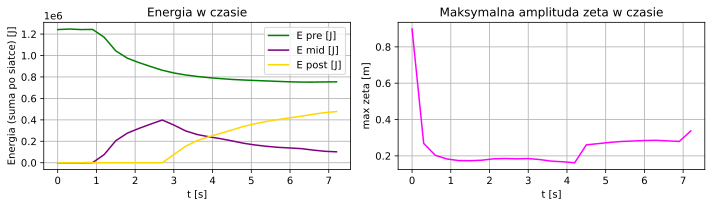

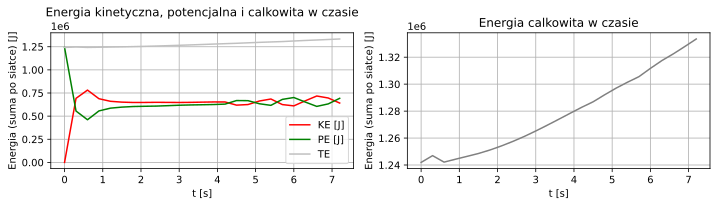

=======W SRODKU=======


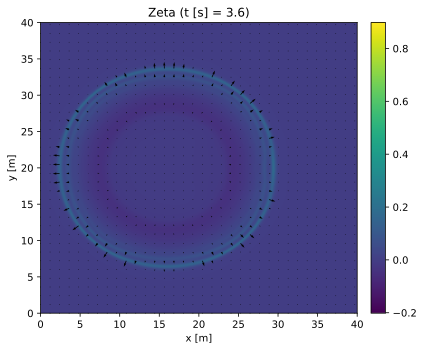

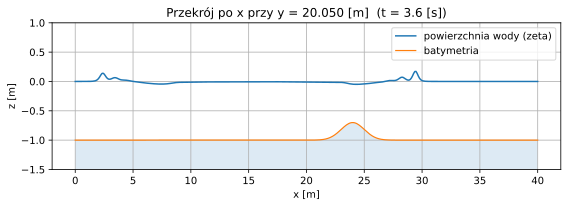

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [5]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.3   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

WYKONANIE DRUGIE

- góra 0.5m

- domena rozmiaru 40 na 40 metrów

- grid rozmiaru 400 na 400

- nt = 1200, t = 7.2s, dt = 0.006s

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


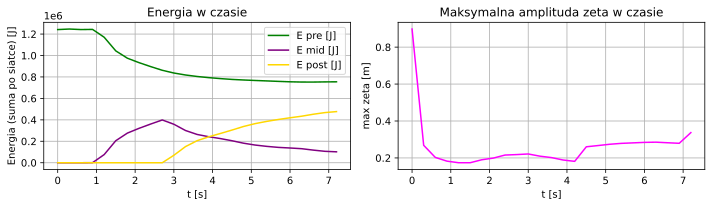

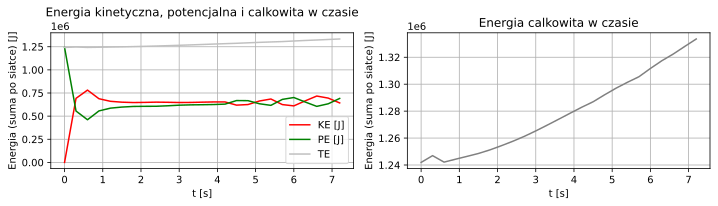

=======W SRODKU=======


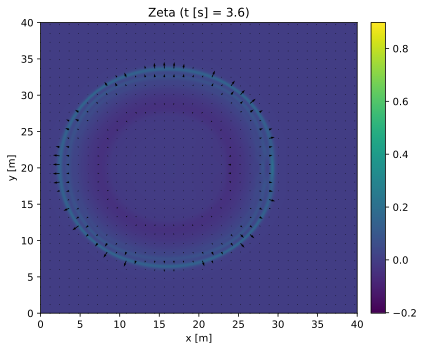

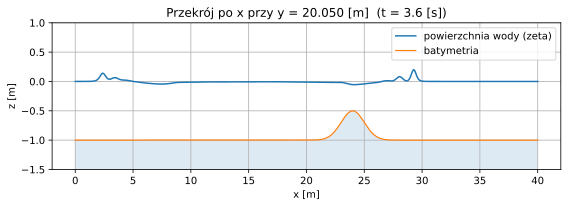

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [6]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.5   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

WYKONANIE TRZECIE

- góra 0.7m

- domena rozmiaru 40 na 40 metrów

- grid rozmiaru 400 na 400

- nt = 1200, t = 7.2s, dt = 0.006s

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


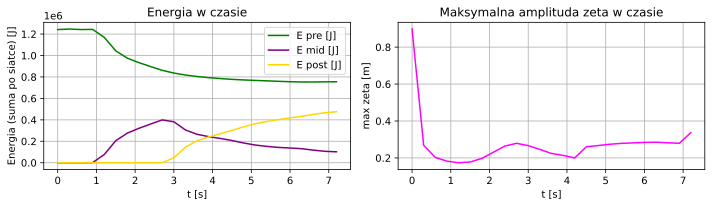

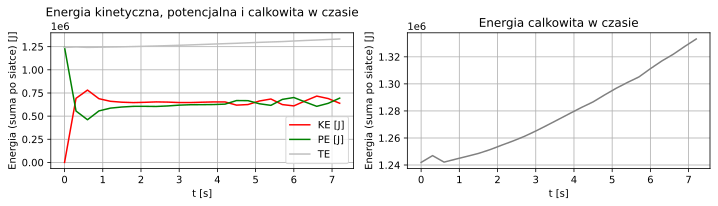

=======W SRODKU=======


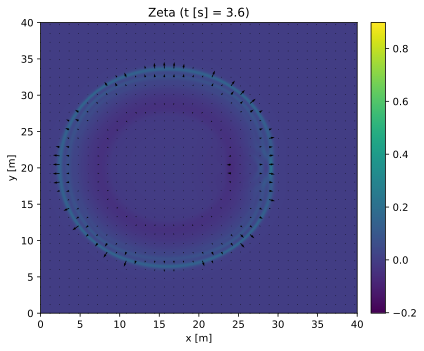

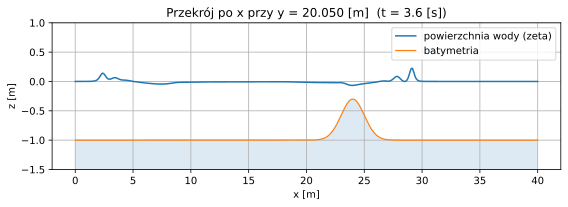

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [7]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.7   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

WYKONANIE CZWARTE

- góra 0.9m

- domena rozmiaru 40 na 40 metrów

- grid rozmiaru 400 na 400

- nt = 1200, t = 7.2s, dt = 0.006s

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


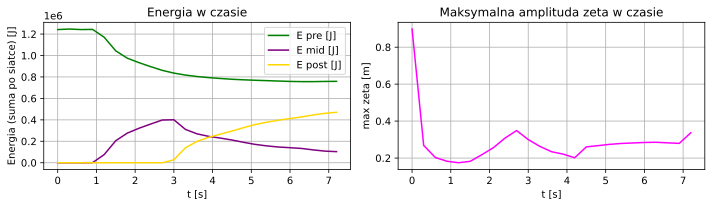

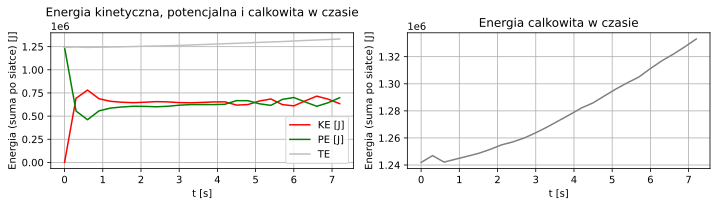

=======W SRODKU=======


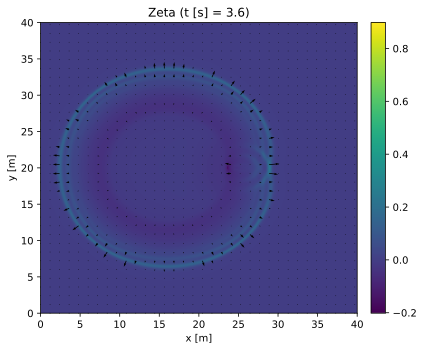

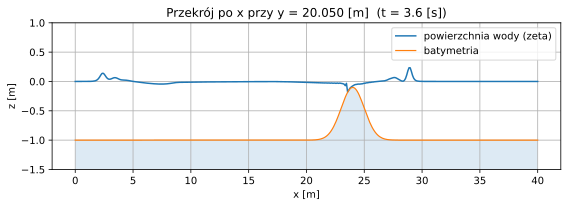

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [8]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.9   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

**NASTĘPNE KROKI**
- podwojenie rozdzielczosci czasowej i przestrzennej i sprawdzenie co sie stanie

- zmiana ksztaltu gorki

**PODWOJONA ROZDZIELCZOSC W CZASIE**

krok czasowy dt rowny  0.003 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


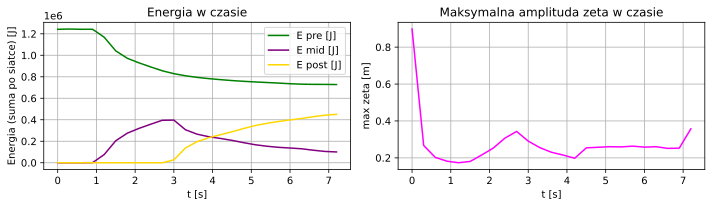

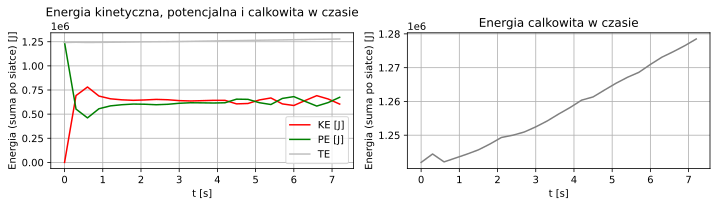

=======W SRODKU=======


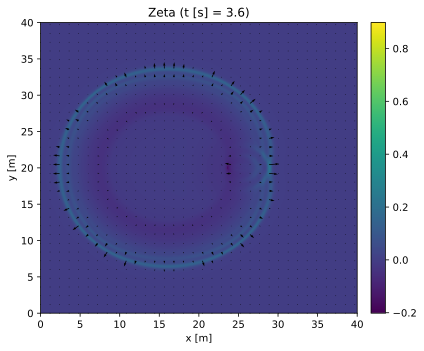

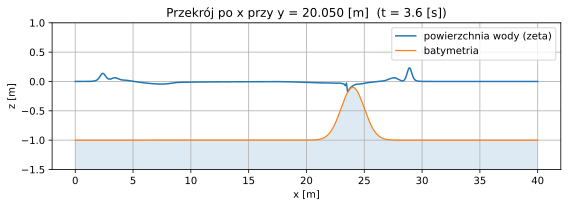

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [9]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.03, 0.03) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 2400 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 100 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.9   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

**DWUKROTNIE ZMNIEJSZONA ROZDZIELCZOSC W CZASIE**

krok czasowy dt rowny  0.012 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


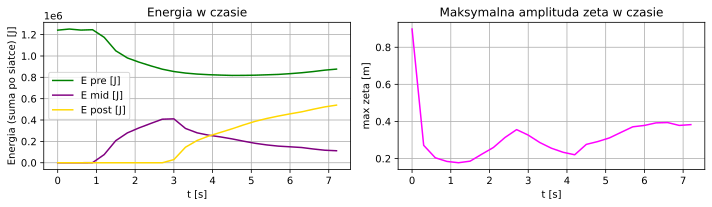

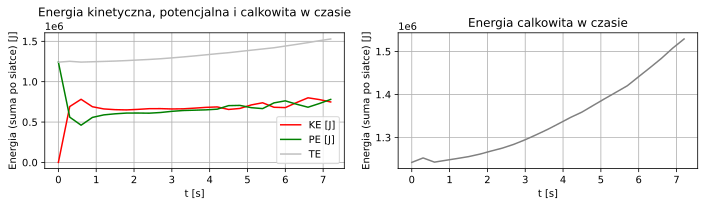

=======W SRODKU=======


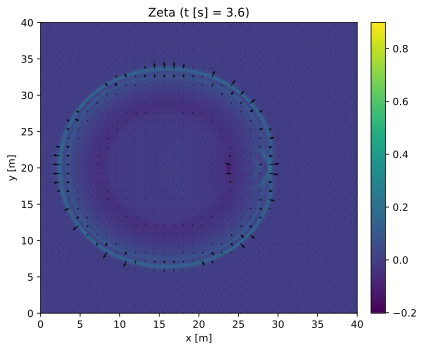

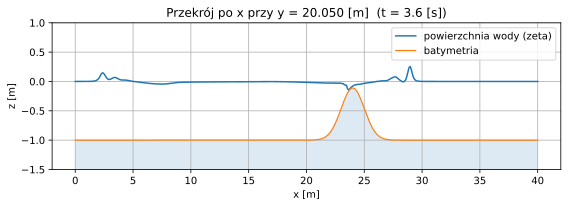

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [10]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.12, 0.12) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 600 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 25 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.89   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

**PODWOJONA ROZDZIELCZOŚĆ PRZESTRZENNA**

krok czasowy dt rowny  0.003 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


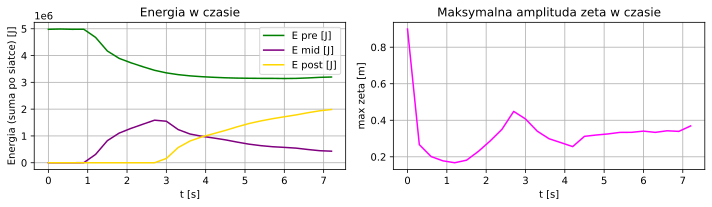

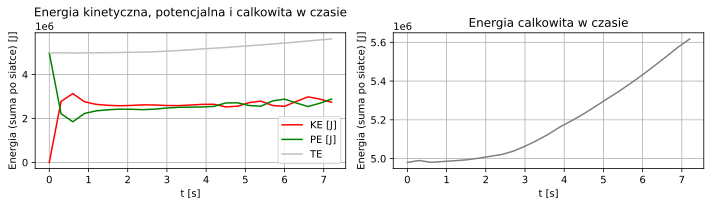

=======W SRODKU=======


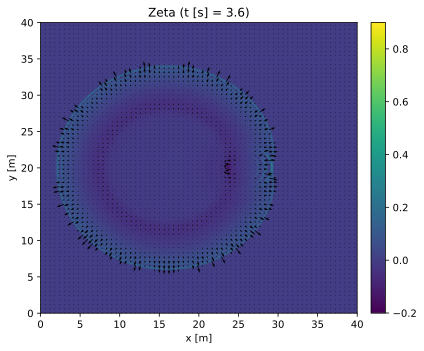

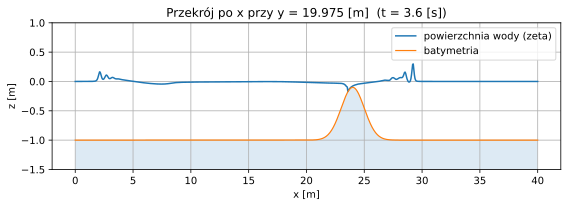

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [11]:
#parametry poczatkowe
grid = (800, 800) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 2400 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 100 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.9   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

**DWUKROTNIE ZMNIEJSZONA ROZDZIELCZOSC PRZESTRZENNA**

krok czasowy dt rowny  0.012 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


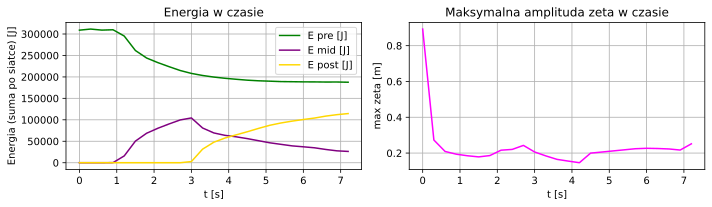

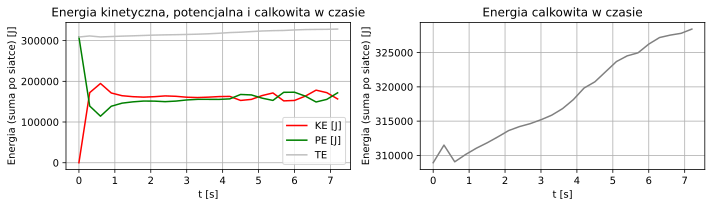

=======W SRODKU=======


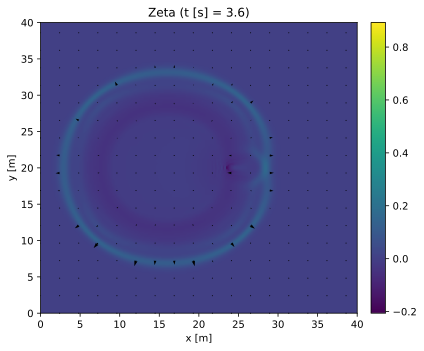

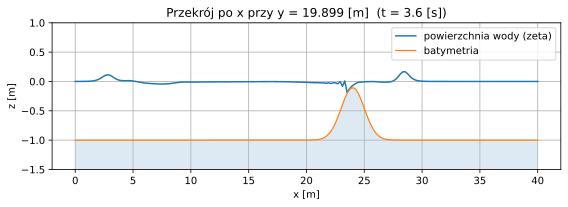

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [16]:
#parametry poczatkowe
grid = (200, 200) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 600 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 25 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.9   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

**ZMIANA KSZTALTU GORKI:**

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


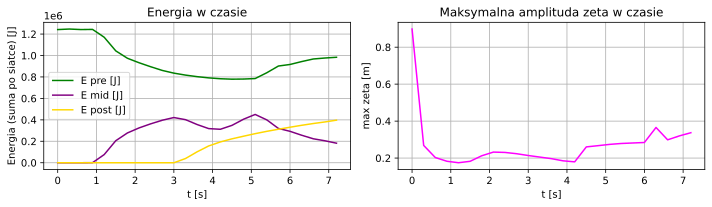

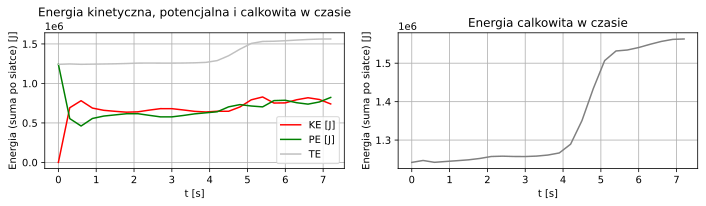

=======W SRODKU=======


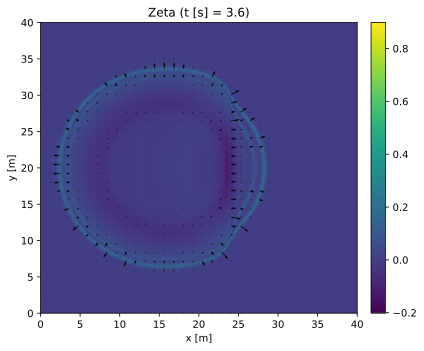

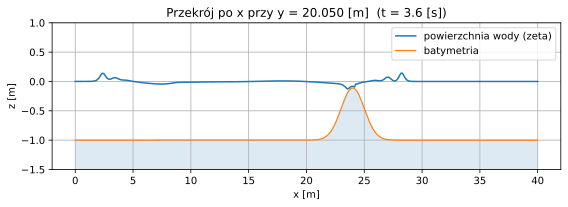

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [18]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.89   #0.9              #duża amplituda
bump_center_x = rozmiarx*(60/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 1.0#0.4            #rozmiar w x
bump_sigma_y = 40.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

krok czasowy dt rowny  0.006 s
Symulacja czasu rzeczywistego odpowiadajacego czasowi  7.2 s


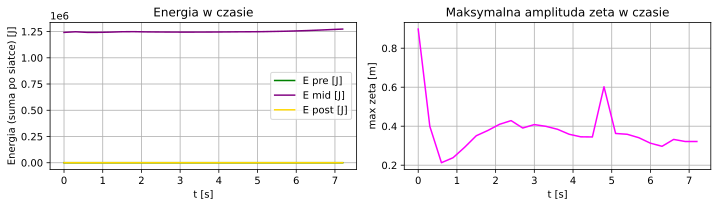

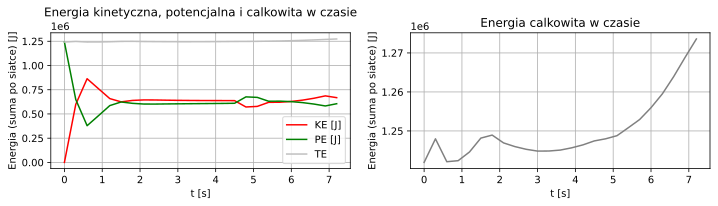

=======W SRODKU=======


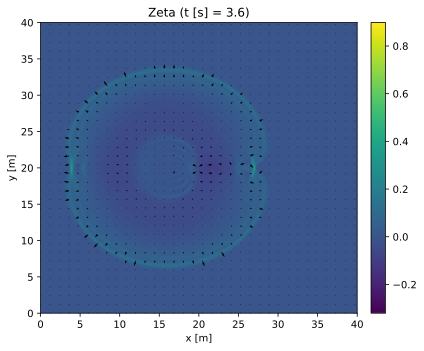

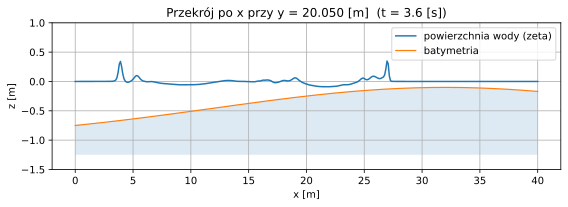

"\nshow_anim(plot2d, range(len(output['h'])))\nshow_anim(plot3d, range(len(output['h'])))\nshow_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))\n##okolo 1min 30s\n"

In [21]:
#parametry poczatkowe
grid = (400, 400) #siatka 400x400
nx, ny = grid
rozmiarx = 40.0 #metry
rozmiary = 40.0 #metry
x = np.linspace(0, rozmiarx, nx) # od zera do 40 metrow, 400 krokow, czyli krok co 0.1m
y = np.linspace(0, rozmiary, ny)
X, Y = np.meshgrid(x, y, indexing='ij')



dt_over_dxy = (0.06, 0.06) #dt/dx = 0.06, dt = dx * 0.06 = 0.1m*0.06s/m = 0.006s
dx = rozmiarx/grid[0]
dt = dx * dt_over_dxy[0]
print("krok czasowy dt rowny ",dt,"s")


nt = 1200 #nt = T/deltat czyli 1200*0.006s = 7.2s
print("Symulacja czasu rzeczywistego odpowiadajacego czasowi ",nt*dt,"s")
outfreq = 50 #12


#BATYMETRIA
base_depth = 1.0
bathymetry = np.ones(grid) * base_depth

#parametry gauss
bump_amp = 0.9   #0.9              #duża amplituda
bump_center_x = rozmiarx*(80/100)#2.0            #środek górki w x
bump_center_y = rozmiary/2#2.0            #środek w y
bump_sigma_x = 20.0#0.4            #rozmiar w x
bump_sigma_y = 1.0#0.4

#gaussowska górka
bump = bump_amp * np.exp(-(((X - bump_center_x)**2) / (2 * bump_sigma_x**2)
                           + ((Y - bump_center_y)**2) / (2 * bump_sigma_y**2)))
bathymetry += -bump #-

#zabezpieczenie (minimalna głębokość)
bathymetry = np.maximum(bathymetry, min_depth)

#war paczatkowe
pulse_center_x = rozmiarx*(40/100) #0.9
pulse_center_y = rozmiary/2#2.0
pulse_sigma = 1.0 #0.02
pulse_amp = 0.9 ####impuls

zeta = np.zeros(grid)
zeta += pulse_amp * np.exp(-(((X - pulse_center_x)**2 + (Y - pulse_center_y)**2) / (2 * pulse_sigma**2))) #tu dalem minus
h_initial = bathymetry + zeta


#przed: x < bump_center_x - L
#nad: |x - bump_center_x| <= L
#za: x > bump_center_x + L
L = 3 * bump_sigma_x    #region półszerokości
pre_mask_x = x < (bump_center_x - L)
mid_mask_x = (x >= (bump_center_x - L)) & (x <= (bump_center_x + L))
post_mask_x = x > (bump_center_x + L)
#rozszerzamy maski do siatki (nx,ny) przez broadcast
pre_mask = np.broadcast_to(pre_mask_x[:, None], grid)
mid_mask = np.broadcast_to(mid_mask_x[:, None], grid)
post_mask = np.broadcast_to(post_mask_x[:, None], grid)


#instancja solvera
integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)
output = integrator(nt=nt, g=g, dt_over_dxy=dt_over_dxy, outfreq=outfreq, eps=eps)
#output['h'], output['uh'], output['vh']

#Przygotowanie czasu w jednostce "kroków" (t/deltat)
n_frames = len(output['h'])
times_steps = np.arange(n_frames) * outfreq   #w jednostce "kroków"
plot_energie()

wykresuj(24,rozmiary) #100
'''
show_anim(plot2d, range(len(output['h'])))
show_anim(plot3d, range(len(output['h'])))
show_anim(xslice_anim_factory(y_coord=rozmiary/2, zlim=(-1.5, 1.0)), range(len(output['h'])))
##okolo 1min 30s
'''

***"Jak model shallow-water zachowuje się dla symulacji fali przemieszczającej się
nad różnej wysokości wzgórzem? Od którego momentu odbite fale stają się widoczne? Jak zmienia się energia fali?"***

**OBSERWACJE:**

W przypadku symulacji dla różnej wysokości gory:

1. fala odbita jest prawie niewidoczna w symulacji z batymetryczna górką wysokosci 0.3m, natomiast w miare wzrostu wysokosci górki pojawia sie coraz bardziej widoczne 'znieksztalcenie' na froncie fali w miejscu wierzchołka górki w momencie przechodzenia fali nad górą. Przy wysokosci gory równej 0.9m widać wyraźna odbita fale, wracajaca w kierunku przeciwnym do kierunku pierwotnego zaburzenia (w otoczeniu wierzcholka gorki batymetrycznej)

2. Energia fali obliczana w obszarach przed, w srodku i na koncu osi x (wzdluz kierunku przechodzenia fali nad gorka) zwieksza sie w obszarze srodkowym wraz ze wzrostem wysokości wzgórza. Jest to najprawdopodobniej spowodowane coraz silniejszym odbiciem wody od podwodnej bariery i, w efekcie, 'pozostawieniem' przez falę części energii przy barierze.

3. Energia calkowita symulacji nie jest stala w czasie i rośnie stopniowo (prawdopodobnie dyfuzja numeryczna lub inne błędy numeryczne). Wzrost energii jest podobny dla górek wysokosci od 0.3m do 0.9m.

Natomiast dla dodatkowych symulacji:

1. W przypadku symulacji z dwukrotnie mniejszym krokiem czasowym wykresy energii w obszarach wygladaja podobnie. Na wykresach całkowitej energii w czasie widać podobne tendencje. Maksymalna wartość energii jest większa dla symulacji z mniejszą rozdzielczością czasową, co może być związane z większą ilością błędów numerycznych (dyfuzji numerycznej).

2. Dla symulacji z dwukrotnie zwiekszona rozdzielczoscia przestrzenna obserwowany jest znaczny wzrost energi calkowitej w czasie (niefizyczny). w symulacjach ze zmniejszona dwukrotnie rozdzielczoscia przestrzenna energia calkowita zaczyna natomiast spadac pod koniec symulacji i zmienia sie w znacznie mniejszym zakresie. Jest to ciekawa obserwacja i zjawisko to pewnie wynika z szczesliwie dobranych parametrow. Po analizie ponownej zauważyłem, że obliczona energia nie była normalizowana, więc w tym przypadku jest jej więcej według mnie dlatego, że była liczona w większej ilości punktów.

3. W symulacjach ze zmiennym ksztaltem wzgorza i wzgorzem ustawionym poprzecznie do przeplywu fali widać łagodniejszy wzrost energii 'za' barierą. Dodatkowo widać też, że energia 'przed' barierą oraz 'na' barierze rośnie w dwóch miejscach na wykresie, symetrycznie względem punktu uderzenia fali w barierę. Jest to spowodowane tym, że fala odbiła się od bariery, a nawet dużo większa jej część niż w innych symulacjach, ponieważ bariera jest szersza w osi y. Dla tego przykladu energia calkowita rosnie bardzo gwałtownie w momencie zderzenia, gwałtowniej niż dla symulacji symetrycznych wzgórz wysokości 0.3m-0.9m. W przypadku symulacji, gdzie wzgorze bylo ustawione wzdluz kierunku fali widać, że fala reaguje z górką po obu stronach od punktu wymuszenia. Energia symulacji rośnie gwałtownie dopiero pod koniec. Jest to spowodowane najprawdopodobniej zderzeniem odbitych fal idących wzdłuż osi y z górką; sytuacja podobna do przykładu górki poprzecznej.

**Podsumowanie**

Model shallow-water w ciekawy sposob pozwala przyblizyc skomplikowane zjawiska fizyczne zwiazane z mechanika plynow. W tym projekcie mialem okazje zbadac interakcje fali generowanej z zaburzenia Gaussowskiego ze wzgorzem generowanym rowniez funkcja Gaussa. Model wytwarzal realistyczne obrazy rozchodzenia sie fal, oczywiscie z pewnymi zastrzezeniami. Przy silnych falach uderzajacych w brzeg gory widoczne byly zaburzenia bardzo kanciaste, ktore nie powstalyby przy prawdziwej cieczy. Zmiana ksztaltu gory pokazala jak fala w dynamiczny sposob reaguje na bardziej skomplikowana batymetrie.


Symulacje z poprawnie oznaczonymi jednostkami pozwoliły przybliżyć otrzymane wyniki do rzeczywistych przykładów.